# Smarter clustering

See if we can cluster based on GIS technology. There are a few reasons to do this: 
1) explainability: Points get assigned to routes because they are IN the polygon. 
2) Updateability: roadworks, LEZ, Circulation plans... zones can be excluded from specific routes to avoid these.
3) extendability: No data no model? No problem with this approach: just make a polygon and assign the polygon to a route. :)

In [1]:
import pandas as pd
import os
import sys
sys.path.append('../utils')
import helpers as h
import matplotlib.pyplot as plt
import random
import numpy as np

try:
    import geopandas as gpd
except:
    ! pip install geopandas

try: 
    import scipy as sp 
except:
    ! pip install scipy


from polycluster import RoutePolygonManager

In [2]:
ITM_DIR = os.path.join(os.getcwd(), '../data/intermediate')
request_df = pd.read_csv(os.path.join(ITM_DIR, 'clean_data.csv'))


C:\Users\Frede\AppData\Local\Temp\ipykernel_18068\3080534967.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  request_df = pd.read_csv(os.path.join(ITM_DIR, 'clean_data.csv'))


## make polygons
Get the actual driven routes and turn them into polygons. 

In [3]:
full_finaldriven = []
for _, df in request_df.groupby('dir'):
    #Time is the timestamp coming from serverlog: compare first request wiht last non-PM request
    # REMEMBER THAT: PM requests where filtered out already.
    last_request_timestamp = df['Time'].max()
    #get the first and last request as dfs: 
    last_request_df = df.loc[df['Time'] == last_request_timestamp]
    full_finaldriven.append(last_request_df)

full_finaldriven_df = pd.concat(full_finaldriven)

In [4]:
full_finaldriven_df

,file_uuid,configurationName,id,lat,long,start_time,end_time,server_task_number,stop_order,dir,...,Date,Time,OptimizationRequestId,RouteId,TriggerType,ConfigurationName,NumberOfTasks,NumberOfTasksInInputPlan,request_day_route_order,request_day_route_is_last
4,34f409b3-9f92-4720-9926-48ca1cbf6f90,CreateSequence,388,0.572716,0.233306,2022-06-17T07:30:00,2022-06-17T23:59:00,2,1,0521_300-20220617,...,2022-06-17 00:00:00,1900-01-01 09:24:16.831000,34f409b3-9f92-4720-9926-48ca1cbf6f90,0521_300,FullOptimization,CreateSequence,2.0,0.0,2.0,False
5,34f409b3-9f92-4720-9926-48ca1cbf6f90,CreateSequence,390,0.565826,0.221868,2022-06-17T08:00:00,2022-06-17T17:00:00,1,2,0521_300-20220617,...,2022-06-17 00:00:00,1900-01-01 09:24:16.831000,34f409b3-9f92-4720-9926-48ca1cbf6f90,0521_300,FullOptimization,CreateSequence,2.0,0.0,2.0,False
6,cb9638db-2817-4ccf-b226-7775c01793a8,EstimateTime,64869,0.650488,0.296025,2022-05-30T00:00:00,2022-05-30T12:00:00,1,1,0521_301-20220530,...,2022-05-30 00:00:00,1900-01-01 06:45:38.424000,cb9638db-2817-4ccf-b226-7775c01793a8,0521_301,TimeCalculation,EstimateTime,154.0,154.0,1.0,False
7,cb9638db-2817-4ccf-b226-7775c01793a8,EstimateTime,64947,0.646361,0.297741,2022-05-30T00:00:00,2022-05-30T12:00:00,2,2,0521_301-20220530,...,2022-05-30 00:00:00,1900-01-01 06:45:38.424000,cb9638db-2817-4ccf-b226-7775c01793a8,0521_301,TimeCalculation,EstimateTime,154.0,154.0,1.0,False
8,cb9638db-2817-4ccf-b226-7775c01793a8,EstimateTime,64971,0.645787,0.298443,2022-05-30T00:00:00,2022-05-30T12:00:00,3,3,0521_301-20220530,...,2022-05-30 00:00:00,1900-01-01 06:45:38.424000,cb9638db-2817-4ccf-b226-7775c01793a8,0521_301,TimeCalculation,EstimateTime,154.0,154.0,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2120926,8a8e6d6b-045c-44bd-9085-cf2d5ec7a6d1,EstimateTime,63699,0.480072,0.301707,2022-06-22T07:30:00,2022-06-22T23:59:00,135,135,0521_O69-20220622,...,2022-06-22 00:00:00,1900-01-01 08:38:33.987000,8a8e6d6b-045c-44bd-9085-cf2d5ec7a6d1,0521_O69,TimeCalculation,EstimateTime,139.0,139.0,7.0,False
2120927,8a8e6d6b-045c-44bd-9085-cf2d5ec7a6d1,EstimateTime,63698,0.479680,0.301925,2022-06-22T07:30:00,2022-06-22T23:59:00,136,136,0521_O69-20220622,...,2022-06-22 00:00:00,1900-01-01 08:38:33.987000,8a8e6d6b-045c-44bd-9085-cf2d5ec7a6d1,0521_O69,TimeCalculation,EstimateTime,139.0,139.0,7.0,False
2120928,8a8e6d6b-045c-44bd-9085-cf2d5ec7a6d1,EstimateTime,63697,0.479792,0.300703,2022-06-22T07:30:00,2022-06-22T23:59:00,137,137,0521_O69-20220622,...,2022-06-22 00:00:00,1900-01-01 08:38:33.987000,8a8e6d6b-045c-44bd-9085-cf2d5ec7a6d1,0521_O69,TimeCalculation,EstimateTime,139.0,139.0,7.0,False
2120929,8a8e6d6b-045c-44bd-9085-cf2d5ec7a6d1,EstimateTime,63696,0.481527,0.300490,2022-06-22T07:30:00,2022-06-22T23:59:00,138,138,0521_O69-20220622,...,2022-06-22 00:00:00,1900-01-01 08:38:33.987000,8a8e6d6b-045c-44bd-9085-cf2d5ec7a6d1,0521_O69,TimeCalculation,EstimateTime,139.0,139.0,7.0,False


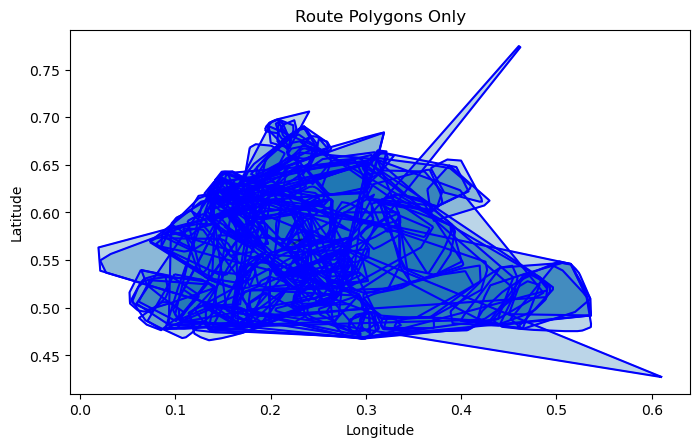

In [5]:
rpm = RoutePolygonManager(full_finaldriven_df)
rpm.create_polygons(latcol = 'lat', longcol = 'long', cluster_id = 'route_id')
rpm.plot_polygons()

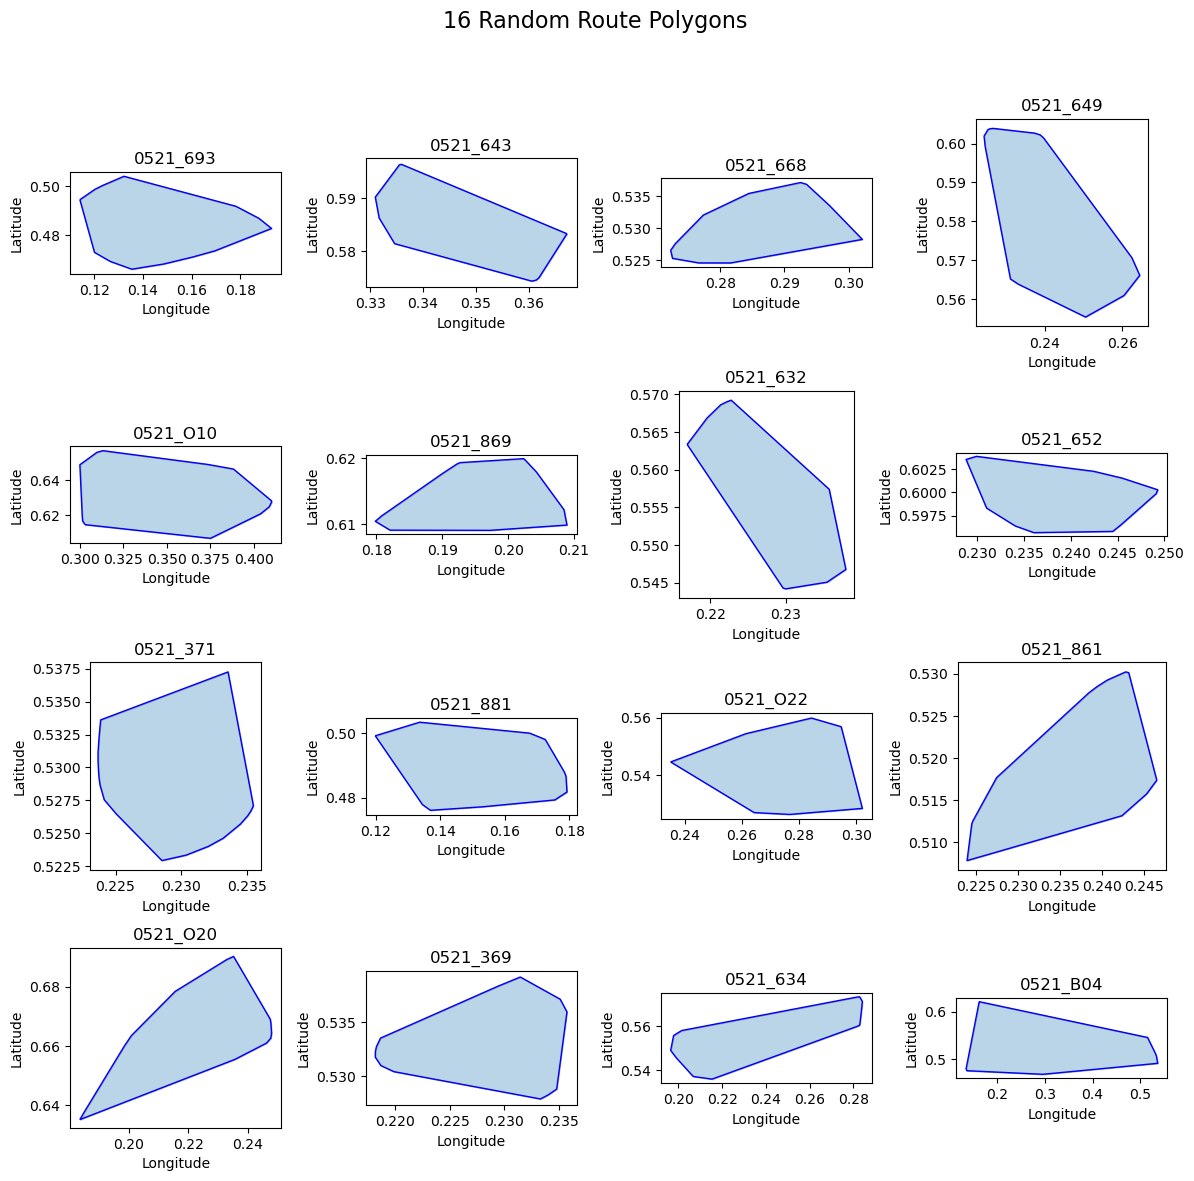

In [6]:
rpm.plot_random_polygons_grid(4)